# Nb-20180314-2218-RandomForest-GainPrediction

In [34]:
STAMP = "20180314-2218"

This is a modification of the previous notebook.

Do a simple random forest to try to predict if a stock sticker will make a gain the next day.


Simplify and see if strong confidence predictions give good results with other tickers...

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from collections import defaultdict
import operator

In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [5]:
import finance as fat

In [6]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [486]:
ticker = 'F'

In [487]:
raw = fat.get_price_data(ticker)
ohlcv = raw

Could not read file: data/yahoo/F.csv. Downloading data for "F" from yahoo.com...
Loaded data for F: 1972-06-01 to 2018-03-14.


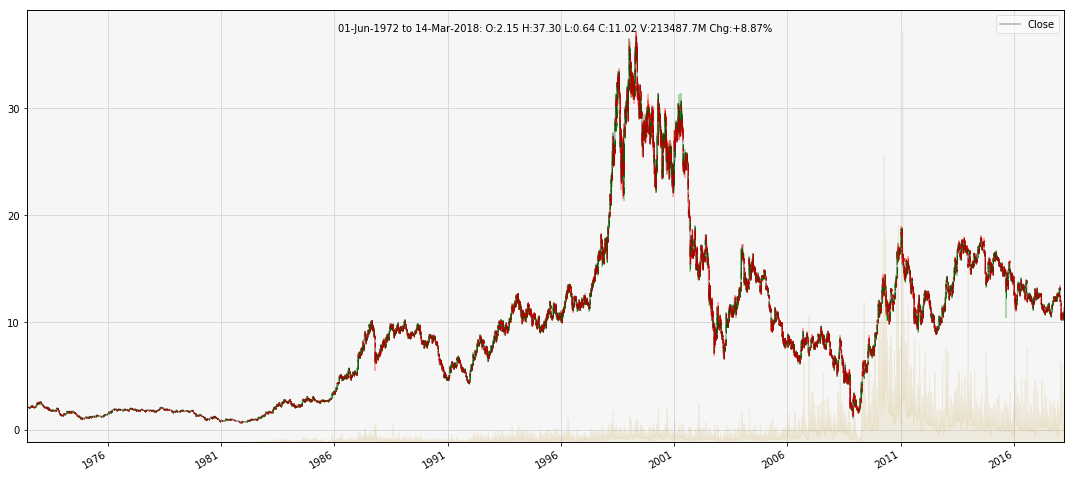

In [488]:
fat.plot_daily_ticker(ohlcv)

### Price and Created Features

Scale the OHLC data to match 'Adj Close'

In [489]:
data = raw.copy()
data = data.div((data['Close']/data['Adj Close']), axis=0)
del data['Adj Close']
del data['Volume']
data.head()

,Open,High,Low,Close
Date,,,,
1972-06-01,0.314129,0.317685,0.314129,0.314722
1972-06-02,0.314722,0.317685,0.312944,0.314129
1972-06-05,0.314129,0.317092,0.312944,0.314129
1972-06-06,0.314129,0.315315,0.309388,0.310573
1972-06-07,0.310573,0.312351,0.308795,0.308795


Get table with prices for last 5 days, and price for following day.

In [490]:
for i in range(-5, 0, 1) :
    data[f'Close {i}d'] = data['Close'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d
Date,,,,,,,,,
1972-06-08,0.308795,0.311166,0.306424,0.306424,0.314722,0.314129,0.314129,0.310573,0.308795
1972-06-09,0.306424,0.307017,0.298719,0.304646,0.314129,0.314129,0.310573,0.308795,0.306424
1972-06-12,0.304646,0.308202,0.302275,0.304646,0.314129,0.310573,0.308795,0.306424,0.304646
1972-06-13,0.304645,0.307609,0.304645,0.307016,0.310573,0.308795,0.306424,0.304646,0.304646
1972-06-14,0.308202,0.314721,0.308202,0.311758,0.308795,0.306424,0.304646,0.304646,0.307016


In [491]:
# SMA: 6, 12, 20, 200
data = fat.add_sma_columns(data, 'Close', [6,12,20,200])
data.tail()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200
Date,,,,,,,,,,,,,
2018-03-08,10.65,10.68,10.48,10.61,10.29,10.40,10.58,10.63,10.63,10.523333,10.598333,10.6085,11.271560
2018-03-09,10.63,10.73,10.57,10.73,10.40,10.58,10.63,10.63,10.61,10.596667,10.609167,10.6235,11.272624
2018-03-12,10.69,10.85,10.68,10.81,10.58,10.63,10.63,10.61,10.73,10.665000,10.624167,10.6375,11.274517
2018-03-13,10.84,10.98,10.73,10.78,10.63,10.63,10.61,10.73,10.81,10.698333,10.630833,10.6415,11.276736
2018-03-14,11.25,11.44,11.01,11.02,10.63,10.61,10.73,10.81,10.78,10.763333,10.641667,10.6630,11.279821


In [492]:
data = fat.add_ema_columns(data, 'Close', [3,6,12,26,50])
data.tail()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50
Date,,,,,,,,,,,,,,,,,,
2018-03-08,10.65,10.68,10.48,10.61,10.29,10.40,10.58,10.63,10.63,10.523333,10.598333,10.6085,11.271560,10.604714,10.588896,10.607555,10.791483,11.112104
2018-03-09,10.63,10.73,10.57,10.73,10.40,10.58,10.63,10.63,10.61,10.596667,10.609167,10.6235,11.272624,10.667357,10.629211,10.626393,10.786929,11.097120
2018-03-12,10.69,10.85,10.68,10.81,10.58,10.63,10.63,10.61,10.73,10.665000,10.624167,10.6375,11.274517,10.738678,10.680865,10.654640,10.788638,11.085860
2018-03-13,10.84,10.98,10.73,10.78,10.63,10.63,10.61,10.73,10.81,10.698333,10.630833,10.6415,11.276736,10.759339,10.709189,10.673926,10.787998,11.073866
2018-03-14,11.25,11.44,11.01,11.02,10.63,10.61,10.73,10.81,10.78,10.763333,10.641667,10.6630,11.279821,10.889670,10.797992,10.727168,10.805183,11.071753


In [493]:
data = fat.add_bollinger_bands(data, 'Close')
data.tail()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,
2018-03-08,10.65,10.68,10.48,10.61,10.29,10.40,10.58,10.63,10.63,10.523333,10.598333,10.6085,11.271560,10.604714,10.588896,10.607555,10.791483,11.112104,10.868967,10.348033
2018-03-09,10.63,10.73,10.57,10.73,10.40,10.58,10.63,10.63,10.61,10.596667,10.609167,10.6235,11.272624,10.667357,10.629211,10.626393,10.786929,11.097120,10.875087,10.371913
2018-03-12,10.69,10.85,10.68,10.81,10.58,10.63,10.63,10.61,10.73,10.665000,10.624167,10.6375,11.274517,10.738678,10.680865,10.654640,10.788638,11.085860,10.898177,10.376823
2018-03-13,10.84,10.98,10.73,10.78,10.63,10.63,10.61,10.73,10.81,10.698333,10.630833,10.6415,11.276736,10.759339,10.709189,10.673926,10.787998,11.073866,10.908592,10.374408
2018-03-14,11.25,11.44,11.01,11.02,10.63,10.61,10.73,10.81,10.78,10.763333,10.641667,10.6630,11.279821,10.889670,10.797992,10.727168,10.805183,11.071753,10.977633,10.348367


In [494]:
scaled = data.div(data['Close'], axis=0)
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,
1972-06-08,1.007737,1.015474,1.000000,1.0,1.027080,1.025145,1.025145,1.013540,1.007738,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
1972-06-09,1.005837,1.007782,0.980545,1.0,1.031128,1.031128,1.019455,1.013619,1.005836,NaN,NaN,NaN,NaN,1.001945,1.002432,1.002675,1.002806,1.002860,NaN,NaN
1972-06-12,1.000000,1.011673,0.992218,1.0,1.031128,1.019455,1.013619,1.005836,1.000000,NaN,NaN,NaN,NaN,1.000834,1.001339,1.001631,1.001798,1.001868,NaN,NaN
1972-06-13,0.992278,1.001930,0.992278,1.0,1.011586,1.005794,0.998072,0.992281,0.992281,NaN,NaN,NaN,NaN,0.996784,0.996077,0.995825,0.995724,0.995690,NaN,NaN
1972-06-14,0.988593,1.009506,0.988593,1.0,0.990496,0.982891,0.977187,0.977187,0.984789,NaN,NaN,NaN,NaN,0.991107,0.987621,0.985928,0.985082,0.984753,NaN,NaN


In [495]:
scaled = scaled.dropna()
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,
1973-03-27,0.990020,1.000000,0.986028,1.0,1.007983,0.994010,0.982034,0.990020,0.990020,0.994011,1.013971,1.030937,1.083856,0.995394,0.998728,1.012151,1.042993,1.080839,1.087976,0.973898
1973-03-28,0.998008,1.003984,0.992032,1.0,0.992033,0.980080,0.988051,0.988051,0.998011,0.991037,1.008467,1.026296,1.081703,0.996707,0.997672,1.008578,1.037887,1.075602,1.083546,0.969047
1973-03-29,0.978599,1.007782,0.978599,1.0,0.957198,0.964982,0.964982,0.974710,0.976653,0.973087,0.983301,1.001460,1.056597,0.986718,0.981699,0.987334,1.012643,1.048509,1.056919,0.946001
1973-03-30,1.013807,1.015779,0.996055,1.0,0.978306,0.978306,0.988168,0.990138,1.013808,0.991455,0.994413,1.012822,1.071267,1.000171,0.996610,1.000818,1.024653,1.060516,1.067054,0.958590
1973-04-02,1.003960,1.007921,1.000000,1.0,0.982179,0.992080,0.994058,1.017821,1.003958,0.998349,0.996039,1.014752,1.075531,1.002065,1.000397,1.004044,1.026583,1.062175,1.068389,0.961115


In [496]:
del scaled['Close']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,
1973-03-27,0.990020,1.000000,0.986028,1.007983,0.994010,0.982034,0.990020,0.990020,0.994011,1.013971,1.030937,1.083856,0.995394,0.998728,1.012151,1.042993,1.080839,1.087976,0.973898
1973-03-28,0.998008,1.003984,0.992032,0.992033,0.980080,0.988051,0.988051,0.998011,0.991037,1.008467,1.026296,1.081703,0.996707,0.997672,1.008578,1.037887,1.075602,1.083546,0.969047
1973-03-29,0.978599,1.007782,0.978599,0.957198,0.964982,0.964982,0.974710,0.976653,0.973087,0.983301,1.001460,1.056597,0.986718,0.981699,0.987334,1.012643,1.048509,1.056919,0.946001
1973-03-30,1.013807,1.015779,0.996055,0.978306,0.978306,0.988168,0.990138,1.013808,0.991455,0.994413,1.012822,1.071267,1.000171,0.996610,1.000818,1.024653,1.060516,1.067054,0.958590
1973-04-02,1.003960,1.007921,1.000000,0.982179,0.992080,0.994058,1.017821,1.003958,0.998349,0.996039,1.014752,1.075531,1.002065,1.000397,1.004044,1.026583,1.062175,1.068389,0.961115


### Volume and Created Features

In [497]:
vol = pd.DataFrame(raw, columns=['Volume'])
vol.head()

,Volume
Date,
1972-06-01,1089200
1972-06-02,1173500
1972-06-05,5208100
1972-06-06,1421400
1972-06-07,671800


In [498]:
# replace 0's, since they cause potential blow-ups
vol = vol.replace(0, 1)
vol.describe()

,Volume
count,1.154800e+04
mean,1.848698e+07
std,2.792384e+07
min,2.968000e+05
25%,4.062800e+06
50%,7.918250e+06
75%,2.240665e+07
max,5.411756e+08


In [499]:
for i in range(-5, 0, 1) :
    vol[f'Volume {i}d'] = vol['Volume'].shift(-i)
vol = vol.dropna()
vol.head()

,Volume,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,
1972-06-08,1036600,1089200.0,1173500.0,5208100.0,1421400.0,671800.0
1972-06-09,6589200,1173500.0,5208100.0,1421400.0,671800.0,1036600.0
1972-06-12,1430100,5208100.0,1421400.0,671800.0,1036600.0,6589200.0
1972-06-13,931400,1421400.0,671800.0,1036600.0,6589200.0,1430100.0
1972-06-14,2939300,671800.0,1036600.0,6589200.0,1430100.0,931400.0


In [500]:
vol = vol.div(vol['Volume'], axis=0)
vol.head()

,Volume,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,
1972-06-08,1.0,1.050743,1.132066,5.024214,1.371214,0.648080
1972-06-09,1.0,0.178094,0.790399,0.215717,0.101955,0.157318
1972-06-12,1.0,3.641773,0.993917,0.469757,0.724844,4.607510
1972-06-13,1.0,1.526090,0.721280,1.112948,7.074511,1.535431
1972-06-14,1.0,0.228558,0.352669,2.241758,0.486544,0.316878


In [501]:
del vol['Volume']
vol.head()

,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,
1972-06-08,1.050743,1.132066,5.024214,1.371214,0.648080
1972-06-09,0.178094,0.790399,0.215717,0.101955,0.157318
1972-06-12,3.641773,0.993917,0.469757,0.724844,4.607510
1972-06-13,1.526090,0.721280,1.112948,7.074511,1.535431
1972-06-14,0.228558,0.352669,2.241758,0.486544,0.316878


In [502]:
vol.describe()

,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
count,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000
mean,1.179543,1.170830,1.162966,1.144144,1.108877
std,0.911116,0.773039,0.722737,0.653384,0.571667
min,0.053789,0.046663,0.038700,0.040510,0.031947
25%,0.696468,0.700804,0.708645,0.726614,0.762572
50%,1.008241,1.012486,1.013739,1.010364,1.005432
75%,1.450641,1.427756,1.426519,1.404464,1.330592
max,55.662561,24.674281,16.582120,12.094252,16.757049


### Join Price and Volume

In [503]:
scaled = scaled.join(vol, how='outer')

In [504]:
scaled['Gain +1d'] = scaled['Close -1d'].shift(-1) < 1.0
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
1972-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.050743,1.132066,5.024214,1.371214,0.648080,False
1972-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.178094,0.790399,0.215717,0.101955,0.157318,False
1972-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.641773,0.993917,0.469757,0.724844,4.607510,False
1972-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.526090,0.721280,1.112948,7.074511,1.535431,False
1972-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.228558,0.352669,2.241758,0.486544,0.316878,False


In [505]:
scaled = scaled.dropna()
scaled.head().T

Date,1973-03-27 00:00:00,1973-03-28 00:00:00,1973-03-29 00:00:00,1973-03-30 00:00:00,1973-04-02 00:00:00
Open,0.99002,0.998008,0.978599,1.01381,1.00396
High,1,1.00398,1.00778,1.01578,1.00792
Low,0.986028,0.992032,0.978599,0.996055,1
Close -5d,1.00798,0.992033,0.957198,0.978306,0.982179
Close -4d,0.99401,0.98008,0.964982,0.978306,0.99208
Close -3d,0.982034,0.988051,0.964982,0.988168,0.994058
Close -2d,0.99002,0.988051,0.97471,0.990138,1.01782
Close -1d,0.99002,0.998011,0.976653,1.01381,1.00396
Close SMA6,0.994011,0.991037,0.973087,0.991455,0.998349
Close SMA12,1.01397,1.00847,0.983301,0.994413,0.996039


In [506]:
scaled.describe()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
count,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,...,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000,11344.000000
mean,1.000976,1.013253,0.986938,0.999755,0.999784,0.999821,0.999866,0.999928,0.999859,0.999713,...,0.999721,0.999466,0.999164,1.067923,0.931110,1.178076,1.169341,1.160871,1.142008,1.106695
std,0.019744,0.018426,0.014197,0.052441,0.046372,0.039567,0.031677,0.022174,0.028612,0.043907,...,0.037243,0.058910,0.086077,0.091269,0.067855,0.909569,0.769458,0.717205,0.646602,0.564130
min,0.720395,1.000000,0.697368,0.516729,0.531598,0.579925,0.617100,0.772093,0.674101,0.653036,...,0.702333,0.677601,0.579639,0.932582,0.265038,0.053789,0.046663,0.038700,0.040510,0.031947
25%,0.991379,1.004243,0.982906,0.972826,0.976401,0.980161,0.983924,0.988888,0.985812,0.977305,...,0.980690,0.968217,0.951493,1.021578,0.906913,0.696968,0.702613,0.709647,0.728865,0.763887
50%,1.000000,1.009291,0.990654,0.999103,1.000000,1.000000,1.000000,1.000000,0.999358,0.998975,...,0.998600,0.996543,0.992917,1.046810,0.946437,1.008287,1.013066,1.013893,1.009054,1.005839
75%,1.010127,1.017495,0.995536,1.024814,1.022282,1.019075,1.015260,1.010874,1.013254,1.019976,...,1.016596,1.025566,1.035572,1.087946,0.973886,1.448573,1.425560,1.424844,1.402908,1.329306
max,1.384615,2.056391,1.000000,2.091346,1.947115,1.774038,1.403846,1.333333,1.582532,1.942708,...,1.781496,2.030190,2.241793,3.215261,1.244956,55.662561,24.674281,16.582120,12.094252,16.757049


### Initial processing

In [507]:
scaled = scaled.reset_index()
scaled.head()

,Date,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,...,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d,Gain +1d
0,1973-03-27,0.990020,1.000000,0.986028,1.007983,0.994010,0.982034,0.990020,0.990020,0.994011,...,1.042993,1.080839,1.087976,0.973898,0.321785,0.406854,0.527635,0.509260,0.408700,True
1,1973-03-28,0.998008,1.003984,0.992032,0.992033,0.980080,0.988051,0.988051,0.998011,0.991037,...,1.037887,1.075602,1.083546,0.969047,1.079773,1.400322,1.351554,1.084673,2.653958,True
2,1973-03-29,0.978599,1.007782,0.978599,0.957198,0.964982,0.964982,0.974710,0.976653,0.973087,...,1.012643,1.048509,1.056919,0.946001,0.972667,0.938793,0.753417,1.843446,0.694602,False
3,1973-03-30,1.013807,1.015779,0.996055,0.978306,0.978306,0.988168,0.990138,1.013808,0.991455,...,1.024653,1.060516,1.067054,0.958590,1.014423,0.814113,1.991955,0.750560,1.080561,False
4,1973-04-02,1.003960,1.007921,1.000000,0.982179,0.992080,0.994058,1.017821,1.003958,0.998349,...,1.026583,1.062175,1.068389,0.961115,2.592023,6.342115,2.389682,3.440359,3.183864,False


In [508]:
add_datepart(scaled, 'Date')
del scaled['Elapsed']
del scaled['Year']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,0.990020,1.000000,0.986028,1.007983,0.994010,0.982034,0.990020,0.990020,0.994011,1.013971,...,13,27,1,86,False,False,False,False,False,False
1,0.998008,1.003984,0.992032,0.992033,0.980080,0.988051,0.988051,0.998011,0.991037,1.008467,...,13,28,2,87,False,False,False,False,False,False
2,0.978599,1.007782,0.978599,0.957198,0.964982,0.964982,0.974710,0.976653,0.973087,0.983301,...,13,29,3,88,False,False,False,False,False,False
3,1.013807,1.015779,0.996055,0.978306,0.978306,0.988168,0.990138,1.013808,0.991455,0.994413,...,13,30,4,89,False,False,False,False,False,False
4,1.003960,1.007921,1.000000,0.982179,0.992080,0.994058,1.017821,1.003958,0.998349,0.996039,...,14,2,0,92,False,False,False,False,False,False


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [509]:
scaled.tail().T

,11339,11340,11341,11342,11343
Open,1.00377,0.99068,0.988899,1.00557,1.02087
High,1.0066,1,1.0037,1.01855,1.03811
Low,0.987747,0.985089,0.987974,0.995362,0.999093
Close -5d,0.96984,0.969245,0.978723,0.986085,0.96461
Close -4d,0.980207,0.986021,0.983349,0.986085,0.962795
Close -3d,0.997172,0.99068,0.983349,0.98423,0.973684
Close -2d,1.00189,0.99068,0.981499,0.995362,0.980944
Close -1d,1.00189,0.988816,0.992599,1.00278,0.978221
Close SMA6,0.991832,0.987574,0.986586,0.992424,0.976709
Close SMA12,0.9989,0.988739,0.982809,0.986163,0.965668


In [510]:
train_cats(scaled)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [511]:
file_name = f'data/tmp/{ticker}-{STAMP}-gain-raw'

In [512]:
os.makedirs('data/tmp', exist_ok=True)
scaled.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [190]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [191]:
dep_col = 'Gain +1d'

In [192]:
df, y, nas = proc_df(df_raw, dep_col)

In [193]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [194]:
len(df_raw)

11954

In [195]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9564, 35), (9564,), (2390, 35))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [196]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Bagging

In [197]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=30, max_features='log2', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.811271434546215, 0.5133891213389121, 0.5293810121288164]


In [198]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[819, 351],
       [812, 408]], dtype=int64)

In [199]:
def plot_metrics(metrics): return metrics.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [200]:
def get_metrics(stamp, y_valid, y_pred, chance) :
    col = ['accuracy', 'precision','recall','f1','chance']
    val = []
    val.append(metrics.accuracy_score(y_valid, y_pred))
    val.append(metrics.precision_score(y_valid, y_pred))
    val.append(metrics.recall_score(y_valid, y_pred))
    val.append(metrics.f1_score(y_valid, y_pred))
    val.append(chance)
    
    return pd.DataFrame(data=[val], columns=col, index=[stamp])

In [201]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
chance = cnf_matrix[1:].sum() / cnf_matrix.sum()

In [202]:
met = get_metrics(STAMP, y_valid, y_pred, chance)

,accuracy,precision,recall,f1,chance
20180314-2218,0.513389,0.537549,0.334426,0.412329,0.51046


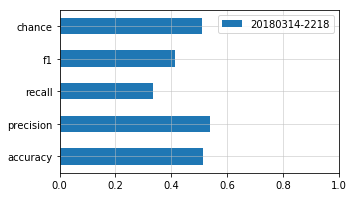

In [203]:
met.T.plot(kind='barh', figsize=(5,3), xlim=(0,1))
met

**^Looks like simplification made a fairly significant difference, previous precision was 0.5321**



In [204]:
fi = rf_feat_importance(m, df)

In [205]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

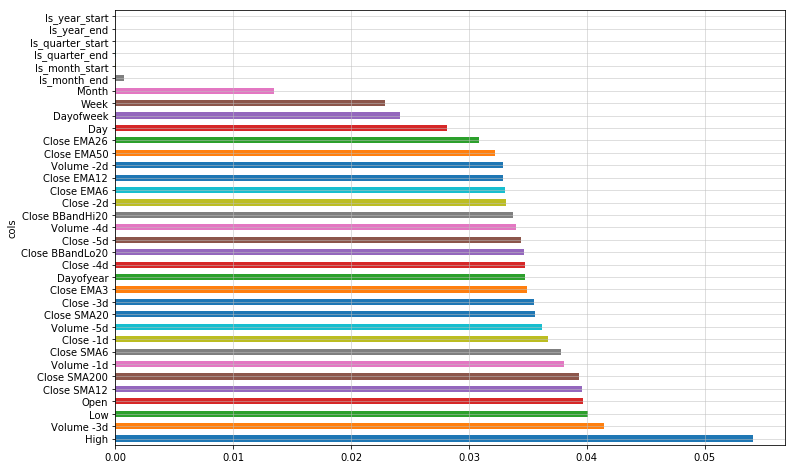

In [206]:
plot_fi(fi)

### Confidence

In [207]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.8 s


(0.45, 0.49749371855331004)

In [208]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [209]:
x['Gain +1d'] = y_valid

In [210]:
hi_conf_gain = x.loc[(x['pred'] - x['pred_std']) > 0.5]
len(hi_conf_gain)

4

In [211]:
hi_conf_gain

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,pred_std,pred,Gain +1d
9581,1.061160,1.072870,0.985259,1.222791,1.151386,1.095034,1.081443,1.051960,1.100436,1.161840,...,281,False,False,False,False,False,False,0.271293,0.92,False
9583,1.070674,1.070899,0.991348,1.176854,1.162247,1.130562,1.074719,1.017416,1.093633,1.199944,...,283,False,False,False,False,False,False,0.346987,0.86,False
9675,1.058433,1.058789,0.997867,1.112244,1.074671,1.084627,1.054048,1.052389,1.062997,1.092885,...,54,False,False,False,False,False,False,0.336303,0.87,True
10297,1.034699,1.041159,0.995755,1.095451,1.050428,1.059616,1.022641,1.049649,1.046298,1.077893,...,222,False,False,False,False,False,False,0.336303,0.87,True


In [212]:
hi_conf_no_gain = x.loc[(x['pred'] + x['pred_std']) < 0.5]
hi_conf_no_gain

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,pred_std,pred,Gain +1d
10339,0.980602,1.000054,0.980066,0.928572,0.936341,0.947648,0.973582,0.977334,0.960579,0.950564,...,283,False,False,False,False,False,False,0.271293,0.08,False


In [213]:
conf_gain = x.loc[x['pred'] > 0.75]
conf_gain = pd.DataFrame(conf_gain, columns=['pred','pred_std', 'Gain +1d'])
len(conf_gain.loc[conf_gain['Gain +1d'] == True])/len(conf_gain)

0.7058823529411765

In [214]:
conf_no_gain = x.loc[x['pred'] < 0.25]
conf_no_gain = pd.DataFrame(conf_no_gain, columns=['pred','pred_std', 'Gain +1d'])
len(conf_no_gain.loc[conf_no_gain['Gain +1d'] == False])/len(conf_no_gain)

0.6842105263157895

Looks like high confidence predictions are much better than chance, let's simplify and see if that holds with other tickers...

### Make predictions with new ticker data

In [513]:
file_name = f'data/tmp/F-{STAMP}-gain-raw'

In [514]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [515]:
dep_col = 'Gain +1d'

In [516]:
df, y, nas = proc_df(df_raw, dep_col)

In [517]:
y_pred = m.predict(df)

In [518]:
met = get_metrics(STAMP, y, y_pred, 0.5)

,accuracy,precision,recall,f1,chance
20180314-2218,0.523184,0.490784,0.430209,0.458504,0.5


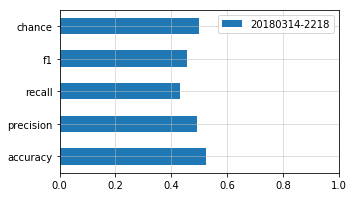

In [519]:
met.T.plot(kind='barh', figsize=(5,3), xlim=(0,1))
met

In [520]:
%time preds = np.stack([t.predict(df) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 8.64 s


(0.38, 0.4853864439804639)

In [521]:
x = df.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [522]:
x['Gain +1d'] = y

In [523]:
conf_gain = x.loc[x['pred'] > 0.75]
conf_gain = pd.DataFrame(conf_gain, columns=['pred','pred_std', 'Gain +1d'])
len(conf_gain.loc[conf_gain['Gain +1d'] == True])/len(conf_gain)

0.5092250922509225

In [524]:
conf_no_gain = x.loc[x['pred'] < 0.25]
conf_no_gain = pd.DataFrame(conf_no_gain, columns=['pred','pred_std', 'Gain +1d'])
len(conf_no_gain.loc[conf_no_gain['Gain +1d'] == False])/len(conf_no_gain)

0.5384615384615384

In [525]:
len(conf_gain)

271

In [526]:
len(conf_no_gain)

156

Tried training model on 'IBM' and then running predictions for all data for tickers:
- MSFT, FB, SPY, GOOG: All good, conf_gain > 60% precision

But, unrelated tickers had very poor prescision:
- IAU, TLT, BTC-USD, F: All bad, conf_gain < 50% precision

Probably because the first group are all highly correlated? (or similar industry?), the last group not so much